In [1]:
# INSTALL OR BATCH LEARNING FAILS.
%pip install scikit-learn==1.5.2

Note: you may need to restart the kernel to use updated packages.


In [57]:
# Reading data and plot it.
import pandas as pd
import matplotlib.pyplot as plt

# Stream learning
from river import compose, preprocessing, linear_model, tree, metrics, evaluate, feature_extraction, \
    utils, stats, compat, drift, stream

# Batch learning 
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import copy

# Load dataset

In [58]:
# Read api request from a csv
df = pd.read_csv("datasets/data.csv")

# Create the target feature and eliminate redundant features
df["temp_diff_6h"] = df["main.temp"].diff(periods=6)
df["target"] = (df["temp_diff_6h"] > 0).astype(int)
df = df.drop(["Unnamed: 0","temp_diff_6h", "weather.main", "weather.description", "weather.icon"], axis = 1)
df.head(2)

,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,wind.gust,clouds.all,weather.id,rain.1h,target
0,1708617600,10.79,9.83,1010,73,9.14,11.61,7.72,290,14.92,75,803,NaN,0
1,1708621200,9.69,7.35,1010,81,8.58,11.40,4.63,290,NaN,75,803,NaN,0


# Descriptive analysis

Numerical features

In [59]:
# Check numerical features and number of nulls
exclude_features = ["dt", "weather.id", "target"]
summary = df.drop(columns=exclude_features).describe().transpose()
summary['null_count'] = df.isnull().sum()

# Drop these two columns because they have too many nulls
df = df.drop(["wind.gust", "rain.1h"], axis = 1)
summary

,count,mean,std,min,25%,50%,75%,max,null_count
main.temp,8105.0,15.223013,4.343804,0.40,12.26,15.26,18.36,30.82,0
main.feels_like,8105.0,14.867462,4.948661,-2.62,11.76,15.08,18.39,34.06,0
main.pressure,8105.0,1016.258606,8.609523,976.00,1012.00,1017.00,1021.00,1038.00,0
main.humidity,8105.0,83.708822,10.288154,0.00,78.00,86.00,91.00,100.00,0
main.temp_min,8105.0,14.090116,4.354793,0.40,11.36,14.32,17.16,29.75,0
main.temp_max,8105.0,16.279006,4.421052,2.47,13.27,16.07,19.40,33.15,0
wind.speed,8105.0,3.732584,2.353262,0.00,2.06,3.13,4.92,18.78,0
wind.deg,8105.0,183.830845,110.814811,0.00,117.00,180.00,280.00,360.00,0
wind.gust,1279.0,8.259398,5.200455,0.45,3.58,7.60,12.35,25.21,6826
clouds.all,8105.0,41.251203,35.334767,0.00,0.00,40.00,75.00,100.00,0


Categorical features

In [60]:
df[['weather.id', "target"]] = df[['weather.id', "target"]].astype('category')
summary = df[['weather.id','target']].describe(include=['category']).transpose()
summary

,count,unique,top,freq
weather.id,8105,16,800,2190
target,8105,2,0,4576


Class distribution

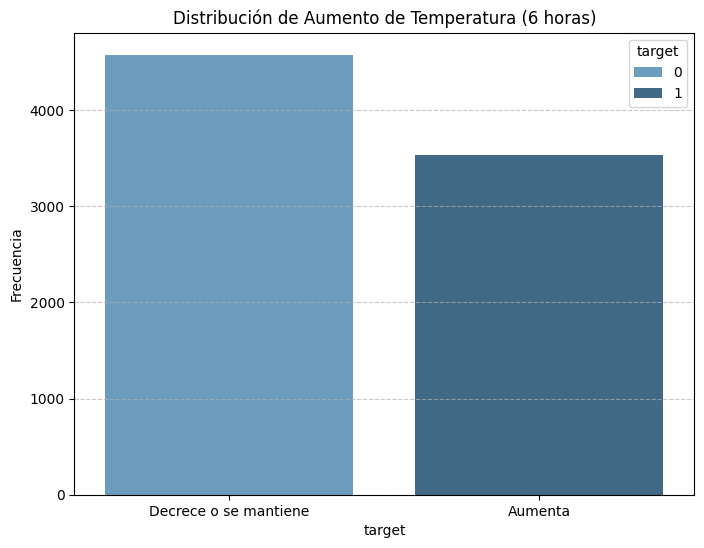

In [61]:
import seaborn as sns

# Class distribution of the dataset
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=df, palette="Blues_d")
plt.ylabel("Frecuencia")
plt.title("Distribución de Aumento de Temperatura (6 horas)")
plt.xticks(ticks=[0, 1], labels=['Decrece o se mantiene', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

Class distribution by time

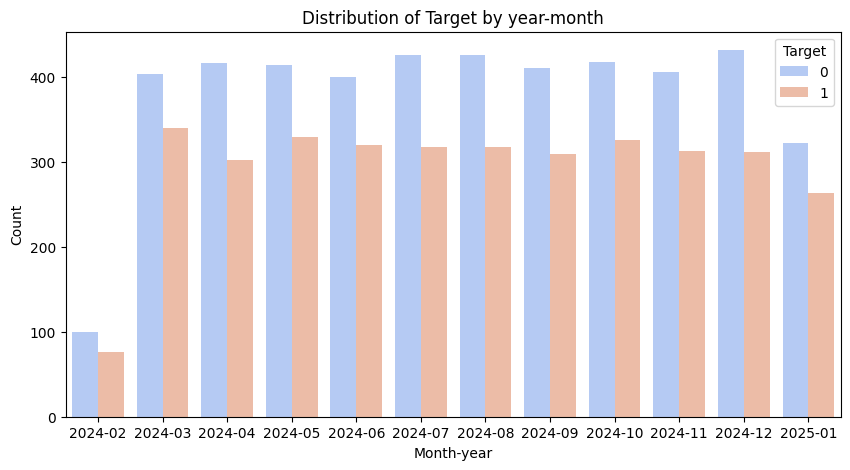

In [62]:
df_plot = copy.deepcopy(df)
df_plot["year_month"] = pd.to_datetime(df_plot["dt"], unit="s").dt.to_period("M")

# Class distribution by month year
plt.figure(figsize=(10, 5))
sns.countplot(data=df_plot, x="year_month", hue="target", palette="coolwarm")
plt.xlabel("Month-year")
plt.ylabel("Count")
plt.title("Distribution of Target by year-month")
plt.legend(title="Target", labels=["0", "1"])
plt.show()

# Train-test partition

In [63]:
# Last 1000 observations are reserved for the test set.
test_df = copy.deepcopy(df.tail(1000))
train_df = copy.deepcopy(df.iloc[:-1000])

X_train = train_df
y_train = X_train.pop('target')
X_test = test_df
y_test = X_test.pop('target')

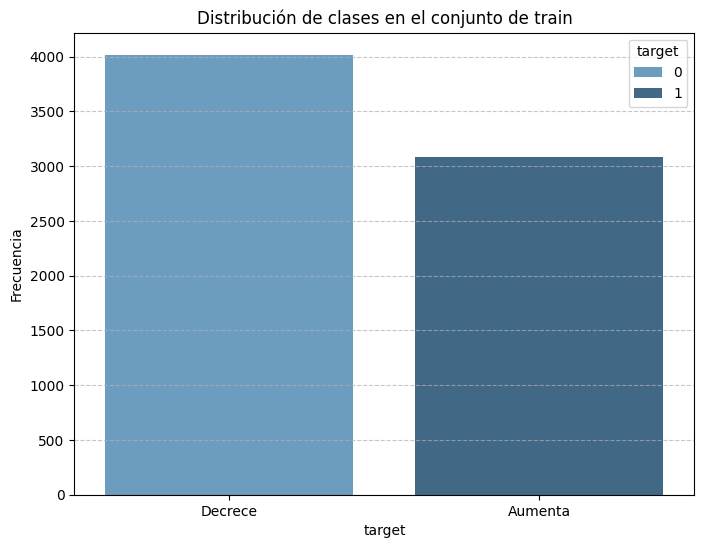

In [64]:
# Class distribution for train set
y_train_df = y_train.to_frame(name="target")
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=y_train_df, palette="Blues_d")
plt.ylabel("Frecuencia")
plt.title("Distribución de clases en el conjunto de train")
plt.xticks(ticks=[0, 1], labels=['Decrece', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

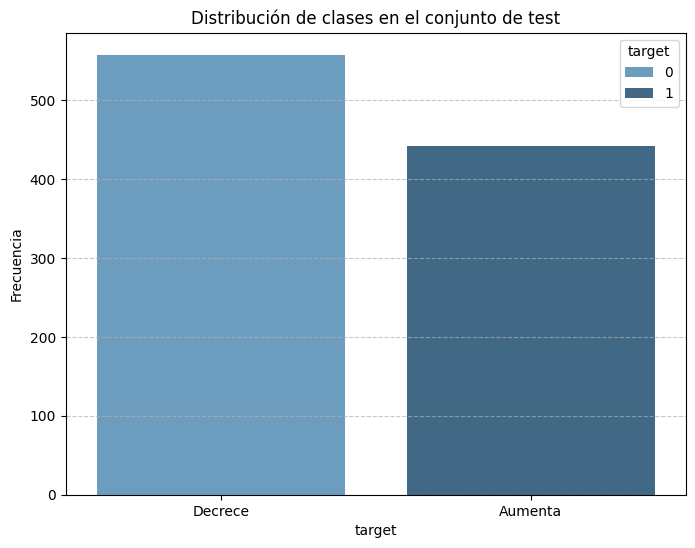

In [65]:
# Class distribution for test set.
y_test_df = y_test.to_frame(name="target")
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=y_test_df, palette="Blues_d")
plt.ylabel("Frecuencia")
plt.title("Distribución de clases en el conjunto de test")
plt.xticks(ticks=[0, 1], labels=['Decrece', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Stream learning results

In [66]:
def create_features(modelo, wrapped=False, colIndex=None):
    """ 
    Creates a river pipeline with a specific preprocessing for given a model.

    Params:
        - modelo: River model to consider.
    """

    cols_rolling = ["main.temp", "main.feels_like", "main.pressure", "main.humidity", "wind.speed", "wind.deg"]
    to_discard = ['Unnamed: 0', 'wind.gust', 'weather.main', 'weather.description', 'weather.icon', 'rain.1h', 'temp_diff_6h'
                  "year_month"]
    
    # when using the river to sklearn wrapper the names of attributes are lost and replaced by their ordered numerical index
    # by mapping using the column index dict, we solve this problem
    if wrapped:
        cols_rolling = list(map(colIndex.get, cols_rolling))
        to_discard = list(map(colIndex.get, to_discard))

    def get_date_features(x):
        # likewise we must translate the attribute name "dt" to its ordered index in case of wrapping
        if wrapped:
            dt = x[colIndex["dt"]]
        else:
            dt = x["dt"]
            
        dt = pd.to_datetime(dt, unit = "s")
        month =  dt.month
        
        x['month'] = month
        return x

    model = compose.FuncTransformer(get_date_features)
        
    model = compose.Discard(*to_discard)
    
    for col in cols_rolling:
        model += feature_extraction.Agg(on = col, by=None, how=utils.Rolling(stats.Mean(), 6))

    model |= preprocessing.StandardScaler()
    model |= modelo

    return model

def stream_learning(X_train, y_train, X_test, y_test, modelo, drift_detect):

    """
    Obtains the results in train and test partition using a specific river pipeline.
    Concept drift is considered using a drift detector, which resets the model when
    a drift is detected.

    Params:
        - X_train: Dataframe with input features in training set.
        - y_train: Dataframe with target in training set.
        - X_test: Dataframe with input features in test set.
        - y_test: Dataframe with target in test set.
        - model: River pipeline to consider.
        - drift_detector: River drift detector to consider.
    """

    # Lists to store concept drift indexes and accuracy over time
    drifts = []
    acc_values = []

    # Intialize model, drift detector and metrics
    drift_detector = copy.deepcopy(drift_detect)
    model = copy.deepcopy(modelo)
    acc2 = metrics.Accuracy()
    report2 = metrics.ClassificationReport()

    counter = 0

    # Concatenate X_train and X_test as in stream learning 
    X = pd.concat([X_train, X_test], axis=0)
    y = pd.concat([y_train, y_test], axis=0)

    for xi, yi in stream.iter_pandas(X, y):

        if drift_detector.drift_detected:
            print(f'Change detected at index {counter}')
            # Store position where drift was detected
            drifts.append(counter)
            # Reset model
            model = copy.deepcopy(modelo)
            # Reset drift detector
            drift_detector = copy.deepcopy(drift_detect)

        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        if y_pred != None:
            # Update drift detector
            drift_detector.update(yi)

        if counter % 100 == 0 and counter!=0:
            report2.update(yi, y_pred)
            acc2.update(yi, y_pred)
            # Save metric over time
            acc_values.append(acc2.get())
        counter += 1

    return acc_values, drifts, report2

def get_models_results(X_train, y_train, X_test, y_test, models, drift_detector):
    
    """
    Store the results for a model over train and test sets.

    Params:
    - X_train: Dataframe with input features in training set.
    - y_train: Dataframe with target in training set.
    - X_test: Dataframe with input features in test set.
    - y_test: Dataframe with target in test set.
    - model: River model to consider.
    - drift_detector: River drift detector to consider.
    """

    accuracies = []
    drifts = []
    reports = []

    for model in models:
        model_instance = create_features(model)
        accuracies_model, drifts_model, report_model = stream_learning(X_train, y_train, X_test, y_test,
                                                                       modelo=model_instance, drift_detect=drift_detector)
        
        accuracies.append(accuracies_model)
        drifts.append(drifts_model)
        reports.append(report_model)

    # Optionally, you can zip the results and print them together
    for i, model in enumerate(models):
        print(f"Results for {model.__class__.__name__}:")
        print("Accuracies:", accuracies[i])
        print("Drifts:", drifts[i])
        print("Report:", reports[i])
        print("\n")

    return accuracies, drifts, reports

def plot_accuracy_dual(acc_list, drifts, colors, labels, title, index_test):
    """
    Plots the results of the model with a detector, visualizing the metrics 
    and concept drift points over time.

    Params:
    - acc_list: List with values of a metric for each model.
    - drifts: List with the detected drifts for each model.
    """

    for i, acc_values in enumerate(acc_list):
        color = colors[i]
        label = labels[i]
        indices = np.arange(len(acc_values))
        indices = indices*100
        plt.plot(indices, acc_values, label=label, color=color, marker='o')

    for i, drift in enumerate(drifts):
        color = colors[i]
        label = labels[i]
        for value in drift:
            plt.axvline(x=value, color=color, linestyle='--')

    plt.axvline(x=index_test, color="red", linestyle='-', label = "Test set start")

    plt.legend()
    plt.xlabel('Data instances processed')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

Results for LogisticRegression:
Accuracies: [0.0, 0.5, 0.3333333333333333, 0.5, 0.6, 0.6666666666666666, 0.7142857142857143, 0.625, 0.6666666666666666, 0.7, 0.7272727272727273, 0.75, 0.7692307692307693, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.8421052631578947, 0.85, 0.8571428571428571, 0.8636363636363636, 0.8695652173913043, 0.875, 0.88, 0.8846153846153846, 0.8888888888888888, 0.8571428571428571, 0.8620689655172413, 0.8333333333333334, 0.8387096774193549, 0.84375, 0.8181818181818182, 0.8235294117647058, 0.8285714285714286, 0.8333333333333334, 0.8378378378378378, 0.8421052631578947, 0.8461538461538461, 0.85, 0.8536585365853658, 0.8571428571428571, 0.8604651162790697, 0.8636363636363636, 0.8666666666666667, 0.8695652173913043, 0.8723404255319149, 0.875, 0.8775510204081632, 0.88, 0.8823529411764706, 0.8846153846153846, 0.8867924528301887, 0.8703703703703703, 0.8727272727272727, 0.875, 0.8771929824561403, 0.8793103448275862, 0.8813559322033898, 0.88333333

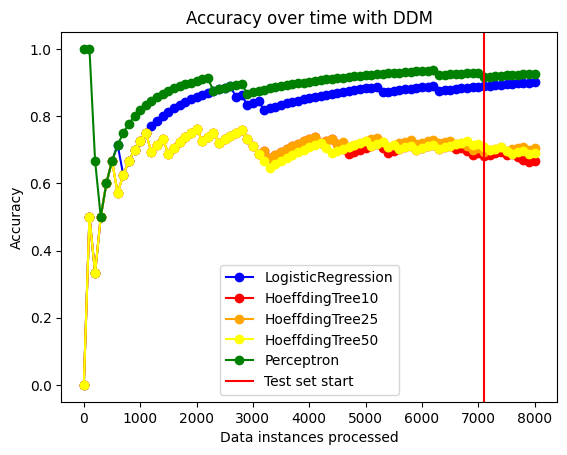

In [67]:
# Define parameters of the experiment.
models = [linear_model.LogisticRegression(),
          tree.HoeffdingTreeClassifier(grace_period=10),
          tree.HoeffdingTreeClassifier(grace_period=25),
          tree.HoeffdingTreeClassifier(grace_period=50),
          linear_model.Perceptron()]
colors = ["blue", "red", "orange", "yellow", "green"]
labels = ["LogisticRegression", "HoeffdingTree10", "HoeffdingTree25", "HoeffdingTree50", "Perceptron"]

# Plot results
acc, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector= drift.binary.DDM(warm_start=100))
plot_accuracy_dual(acc, drifts, colors, labels, title = "Accuracy over time with DDM", index_test = len(X_train)+1)

Change detected at index 264
Change detected at index 500
Change detected at index 837
Change detected at index 264
Change detected at index 500
Change detected at index 837
Results for LogisticRegression:
Accuracies: [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.2857142857142857, 0.25, 0.3333333333333333, 0.3, 0.36363636363636365, 0.4166666666666667, 0.46153846153846156, 0.5, 0.5333333333333333, 0.5, 0.5294117647058824, 0.5555555555555556, 0.5789473684210527, 0.6, 0.6190476190476191, 0.6363636363636364, 0.6521739130434783, 0.6666666666666666, 0.68, 0.6923076923076923, 0.7037037037037037, 0.6785714285714286, 0.6896551724137931, 0.6666666666666666, 0.6774193548387096, 0.6875, 0.6666666666666666, 0.6764705882352942, 0.6857142857142857, 0.6944444444444444, 0.7027027027027027, 0.7105263157894737, 0.717948717948718, 0.725, 0.7317073170731707, 0.7380952380952381, 0.7441860465116279, 0.75, 0.7555555555555555, 0.7608695652173914, 0.7659574468085106, 0.7708333333333334, 0.775

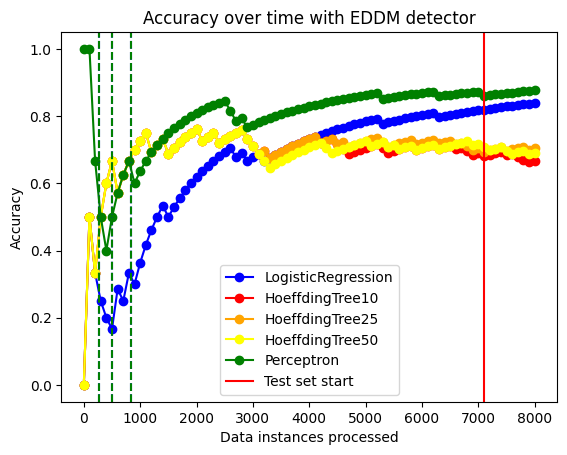

In [68]:
# Plot results
acc, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector= drift.binary.EDDM(warm_start=100))
plot_accuracy_dual(acc, drifts, colors, labels, title = "Accuracy over time with EDDM detector", index_test = len(X_train)+1)

# Batch learning results

In [70]:
X_train.columns

Index(['dt', 'main.temp', 'main.feels_like', 'main.pressure', 'main.humidity',
       'main.temp_min', 'main.temp_max', 'wind.speed', 'wind.deg',
       'clouds.all', 'weather.id'],
      dtype='object')

In [71]:
X_test.columns

Index(['dt', 'main.temp', 'main.feels_like', 'main.pressure', 'main.humidity',
       'main.temp_min', 'main.temp_max', 'wind.speed', 'wind.deg',
       'clouds.all', 'weather.id'],
      dtype='object')

In [72]:
river_model = linear_model.LogisticRegression()

colIndex = {v: k for k, v in enumerate(X_train.columns)}
river_pipeline = create_features(river_model, wrapped=True, colIndex=colIndex)

sk_pipeline = compat.convert_river_to_sklearn(river_pipeline)
sk_pipeline

Pipeline(steps=[('TransformerUnion',
                 River2SKLTransformer(river_estimator=TransformerUnion (
  Discard (
    None
  ),
  Agg (
    on=1
    by=None
    how=Rolling (
      obj=Mean ()
      window_size=6
    )
  ),
  Agg (
    on=2
    by=None
    how=Rolling (
      obj=Mean ()
      window_size=6
    )
  ),
  Agg (
    on=3
    by=None
    how=Rolling (
      obj=Mean ()
      window_size=6
    )
  ),
  Agg (
    on=4
    by=None
    how=Rolling (
      obj=Mean ()
      window_size=6
    )
  ),
  Agg (
    on=7
    by=None
    how=Rolling (
      obj=Mea...
                ('StandardScaler',
                 River2SKLTransformer(river_estimator=StandardScaler (
  with_std=True
))),
                ('LogisticRegression',
                 River2SKLClassifier(river_estimator=LogisticRegression (
  optimizer=SGD (
    lr=Constant (
      learning_rate=0.01
    )
  )
  loss=Log (
    weight_pos=1.
    weight_neg=1.
  )
  l2=0.
  l1=0.
  intercept_init=0.
  intercept_lr=Constant (
    learning_rate=0.01
  )
  clip_gradient=1e+12
  initializer=Zeros ()
)))])

In [73]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, roc_auc_score

# Define a determistic cross-validation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate the performance for each fold of the cross validation
scorer = make_scorer(roc_auc_score)
scores = cross_val_score(sk_pipeline, X_train, y_train, scoring=scorer, cv=cv)

print(f'ROC AUC: {scores.mean():.4f} (± {scores.std():.4f})')

ROC AUC: 0.6604 (± 0.0080)


In [74]:
sk_pipeline.fit(X_train, y_train).score(X_test, y_test)

0.609